#### These next three chunks are just a bunch of import statements.

### Testing how to prepare LRP Confidence Plots.

In [71]:
%matplotlib inline
##so-called "math" related imports
from netCDF4 import Dataset as ncread
import numpy as np
from scipy.io import loadmat
import pandas as pd
import h5py
import math
from random import seed
from random import randint
from random import sample
from scipy.ndimage import gaussian_filter
from sklearn.metrics import brier_score_loss
import xarray as xr

import pickle

##plotting related imports
import matplotlib.pyplot as plt
from matplotlib import rcParams #For changing text properties
import cmocean #A package with beautiful colormaps
from cartopy import crs as ccrs #Useful for plotting maps
import cartopy.util #Requires separate import
from cartopy.util import add_cyclic_point
import cartopy.feature as cf
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.path as mpath
import matplotlib.colors as mcolors

In [72]:
##import tensorflow/keras related files
import tensorflow as tf    
#tf.compat.v1.disable_v2_behavior() # <-- HERE !

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Activation, Reshape, Flatten, LSTM, Dense, Dropout, Embedding, Bidirectional, GRU
from tensorflow.keras import Sequential
from tensorflow.keras import initializers, regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import constraints
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras.callbacks import EarlyStopping

In [73]:
tf.compat.v1.disable_eager_execution()
import innvestigate
import investigate

In [74]:
##import climo probability calculation 
from climoprobs import climo

#### Upload data. 

In [75]:
#inputs
infile = open("./data/ANN/1118_filtered_gph.p", 'rb') 
input = pickle.load(infile)
infile.close()

#outputs
infile = open("./data/ANN/1118_class_filt.p", 'rb')
temp = pickle.load(infile)
infile.close()
#temp = temp.flatten()

#climo
#infile = open("./data/ANN/eur_climoprob_filt.p", 'rb')
#climo = pickle.load(infile)
#infile.close()
#temp = temp.flatten()

In [76]:
##input shape (samples, lat, lon), these will be different from the output
input.shape

(63, 151, 21, 37)

In [77]:
temp = temp.reshape(63,151)

In [78]:
##create two day lag in datasets overlap
temp_n = np.zeros((63,149))
input_n = np.zeros((63,149,21,37))

for i in range(63):
    for j in range(149):
        temp_n[i,j] = temp[i,j+2]
        input_n[i,j] = input[i,j,:,:]
        

In [79]:
##output shape (samples, lat, lon), these will be different from the input
temp_n.shape

(63, 149)

In [80]:
##Set X_all and Y_all datasets
X_all = np.copy(input_n.reshape(9387,777))
Y_all = np.copy(temp_n.reshape(9387))

##training data partition out
X_tri = X_all[:8791,:]
Y_tri = Y_all[:8791]

#testing data partition out
X_tes = X_all[8791:,:]
Y_tes = Y_all[8791:]

#Convert the Y array into a categorical array. This means we will create one-hot vector labels for all of the inputs.
# The one-hot vectors have an index for each possible output category (two in our case)
# A "1" is put in the index corresponding to the category to which the sample belongs
Y_all = keras.utils.to_categorical(Y_all)
Y_tri = keras.utils.to_categorical(Y_tri)
Y_tes= keras.utils.to_categorical(Y_tes)

In [81]:
##checking my data for NaN of Infs because I need to make sure this doesn't cause
#the model to throw back no loss

if np.any(np.isnan(X_all)) or np.any(np.isinf(X_all)):
    print("NaN or Inf values found in X_all!")

if np.any(np.isnan(Y_all)) or np.any(np.isinf(Y_all)):
    print("NaN or Inf values found in Y_all!")

### Begin establishing specifics of model.

In [82]:
##set 6 years of data for validation
frac_ind = 894
frac_ind

894

In [83]:
##checking to make sure shape was properly one hot encoded
Y_all.shape

(9387, 2)

In [84]:
##class weight creator for the instance where now I have a four dimensional output array 
def class_weight_creator(Y):
    class_dict = {}
    Y_reshaped = Y.reshape(-1, Y.shape[-1])
    weights = np.max(np.sum(Y_reshaped, axis=0)) / np.sum(Y_reshaped, axis=0)
    for i in range(Y.shape[-1] ):
        class_dict[i] = weights[i]
        
    return class_dict

In [85]:
##number of input nodes
numb_int = X_all.shape[-1]

##fraction of training data
X_validation = X_tri[0:frac_ind]
Y_validation = Y_tri[0:frac_ind]
        
X_train = X_tri[frac_ind:len(X_tri)]
Y_train = Y_tri[frac_ind:len(Y_tri)]

X_test = X_tes
Y_test = Y_tes

In [86]:
Y_train.shape

(7897, 2)

In [87]:
numb_int

777

In [88]:
##do the class_dict weights
class_weight = class_weight_creator(Y_train)
class_weight

{0: 1.0543704, 1: 1.0}

### Model Arcitecture.

In [89]:
def basic_ANN(number_inputs,num_cats,n1,n2,rl1,rl2,learn,epochs):
    
    input_tensor = Input(shape=(int(number_inputs),))
    
    layer1 = layers.Dense(n1, activation='relu', use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2= rl1))(input_tensor)
    
    layer1 = layers.Dense(n2, activation='relu',use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2=rl2))(layer1)

    #decay_rate = learn / epochs
    output_tensor = layers.Dense(num_cats,activation='softmax')(layer1)
    model = Model(input_tensor, output_tensor)
    model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=learn),
              loss = 'categorical_crossentropy', #Our loss function is based on categorical error
              metrics=[keras.metrics.categorical_accuracy], #We will print out the categorical accuracy as the network is trained
              )
    return model

In [90]:
######
batch_size = 256 #The number of samples the network sees before it backpropagates (batch size)
epochs = 50 #The number of times the network will loop through the entire dataset (epochs)
shuffle = True #Set whether to shuffle the training data so the model doesn't see it sequentially 
verbose = 2 #Set whether the model will output information when trained (0 = no output; 2 = output accuracy every epoch)

In [91]:
Y_validation.shape

(894, 2)

In [123]:
##create model.
model = basic_ANN(numb_int, 2, 128, 4, 0.38, 0.64, 0.001, epochs)

early_stopping = EarlyStopping(monitor='val_loss',patience=4,restore_best_weights=True,verbose=1)

In [124]:
model.fit(X_train, Y_train, validation_data=(X_validation, Y_validation),
          batch_size=batch_size, epochs=epochs, shuffle=shuffle,class_weight = class_weight, callbacks=[early_stopping])

Train on 7897 samples, validate on 894 samples
Epoch 1/50
5376/7897 [===================>..........] - ETA: 0s - loss: 115.8309 - categorical_accuracy: 0.5435

2024-11-19 21:08:39.855452: W tensorflow/c/c_api.cc:305] Operation '{name:'training_2/Adam/dense_6/bias/v/Assign' id:1236 op device:{requested: '', assigned: ''} def:{{{node training_2/Adam/dense_6/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_2/Adam/dense_6/bias/v, training_2/Adam/dense_6/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7897/7897 [==============================] - 0s 23us/sample - loss: 109.5539 - categorical_accuracy: 0.5284 - val_loss: 93.5961 - val_categorical_accuracy: 0.5190
Epoch 2/50
7897/7897 [==============================] - 0s 11us/sample - loss: 86.2314 - categorical_accuracy: 0.4875 - val_loss: 78.1106 - val_categorical_accuracy: 0.5201
Epoch 3/50
7897/7897 [==============================] - 0s 11us/sample - loss: 70.8532 - categorical_accuracy: 0.4874 - val_loss: 63.3163 - val_categorical_accuracy: 0.5201
Epoch 4/50
7897/7897 [==============================] - 0s 11us/sample - loss: 57.0876 - categorical_accuracy: 0.4879 - val_loss: 50.7648 - val_categorical_accuracy: 0.5201
Epoch 5/50
7897/7897 [==============================] - 0s 11us/sample - loss: 45.6960 - categorical_accuracy: 0.4885 - val_loss: 40.6385 - val_categorical_accuracy: 0.5168
Epoch 6/50
7897/7897 [==============================] - 0s 12us/sample - loss: 36.5940 - categorical_accuracy: 0.4882 - val_loss: 32.5962 - val_c

In [125]:
train_loss=model.history.history['loss']
val_loss=model.history.history['val_loss']
    
cat_acc=model.history.history['categorical_accuracy']
val_acc=model.history.history['val_categorical_accuracy']
        
pred = model.predict(X_all)
pred_val = model.predict(X_validation)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-11-19 21:08:45.791802: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_6/Softmax' id:922 op device:{requested: '', assigned: ''} def:{{{node dense_6/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_6/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


<bound method Axes.legend of <Axes: title={'center': 'Accuracy'}, xlabel='Epoch', ylabel='Acc'>>

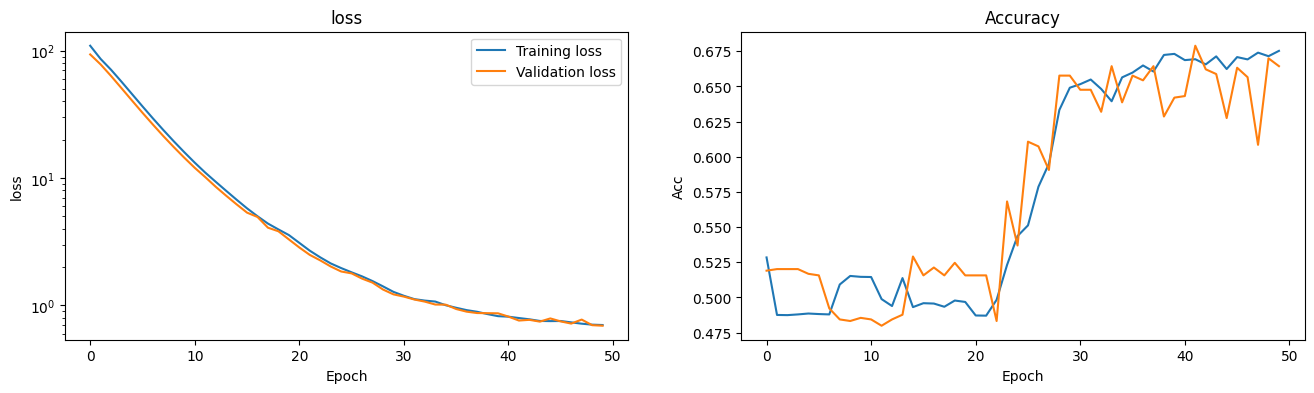

In [126]:
# Look at the optimization history
fig, (ax1,ax2) = plt.subplots(1,2, figsize=plt.figaspect(0.25))
ax1.plot(train_loss, label='Training loss')
ax1.plot(val_loss, label='Validation loss')
ax1.set_yscale('log')
ax1.set_title('loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('loss')
ax1.legend()

ax2.plot(cat_acc, label='Training ACC')
ax2.plot(val_acc, label='Validation ACC')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Acc')
ax2.legend

## Here is where I start throwing together the LRP Code. 

The first part of this is going to be distinguishing the accuracy measurement and picking out where the confidence is  >90th percentile and making an accurate predcition. 

In [127]:
#from google gemini, thanks google
def calculate_accuracy(y_true, y_prob, threshold=0.5):
    """
    Calculates accuracy given true labels and predicted probabilities.
    Args:
        y_true: Array of true labels (e.g., [0, 1, 1, 0]).
        y_prob: Array of predicted probabilities (e.g., [0.3, 0.7, 0.9, 0.2]).
        threshold: Threshold to convert probabilities to binary predictions.
    Returns:
        Accuracy score (float).
    """

    y_pred = (y_prob >= threshold).astype(int)
    return np.mean(y_true == y_pred)

In [128]:
##conducting this on testing data
q90 = np.percentile(pred_test,90,axis=0) ##identify the threshold for the 90th percentile of confidence
q90

array([0.66026187, 0.74882668])

In [129]:
##go through and see where the threshold is exceeded; these are actual index values. 
great90 = [i for i, row in enumerate(pred_test)
           if any(pred_test > q90[i] for i, pred_test in enumerate(row))]

##classify the accuracy of predicitons
correct_pos = []
correct_neg = []

false_pos = []
false_neg = []

for j in range(len(great90)):
    if pred_test[j,0] < pred_test[j,1] and Y_test[j,0] == 0:
        correct_pos.append(great90[j])
    elif pred_test[j,0] > pred_test[j,1] and Y_test[j,0] == 1:
        correct_neg.append(great90[j])
    elif pred_test[j,0] < pred_test[j,1] and Y_test[j,0] == 1:
        false_pos.append(great90[j])
    elif pred_test[j,0] > pred_test[j,1] and Y_test[j,0] == 0:
        false_neg.append(great90[j])
        
# Create the arrays of probabilities and actual values that exceed the 90th percentile
test90 = pred_test[great90]
test90_norm = Y_test[great90]

print(len(test90))
print(len(test90_norm))

84
84


In [130]:
acc = calculate_accuracy(test90_norm,test90)
acc

0.7261904761904762

In [131]:
print(len(correct_pos))
print(len(correct_neg))
print(len(false_pos))
print(len(false_neg))

20
29
14
21


In [132]:
# Creating an analyzer
model_wo_sm = innvestigate.model_wo_softmax(model)
gradient_analyzer = innvestigate.create_analyzer("deep_taylor", model_wo_sm)

In [102]:
# Applying the analyzer
analysis = gradient_analyzer.analyze(X_train)

2024-11-19 18:25:31.338834: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_11/Assign' id:1460 op device:{requested: '', assigned: ''} def:{{{node kernel_11/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_11, kernel_11/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-19 18:25:31.379277: W tensorflow/c/c_api.cc:305] Operation '{name:'gradients_8/MaxNeuronSelection_1/Max_grad/range' id:1510 op device:{requested: '', assigned: ''} def:{{{node gradients_8/MaxNeuronSelection_1/Max_grad/range}} = Range[Tidx=DT_INT32, _class=["loc:@MaxNeuronSelection_1/Max"], _has_manual_control_dependencies=true](gradients_8/MaxNeuronSelection_1/Max_grad/range/start, gradients_8/MaxNeuronSelection_1/Max_grad/Size, gradients_8/MaxNe

In [133]:
posXtrain = X_test[correct_pos]
posXtrain_grad = gradient_analyzer.analyze(posXtrain)

negXtrain = X_test[correct_neg]
negXtrain_grad = gradient_analyzer.analyze(negXtrain)

2024-11-19 21:08:57.336540: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_13/Assign' id:1518 op device:{requested: '', assigned: ''} def:{{{node kernel_13/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_13, kernel_13/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-11-19 21:08:57.376331: W tensorflow/c/c_api.cc:305] Operation '{name:'gradients_8/MaxNeuronSelection_1/Max_grad/range' id:1528 op device:{requested: '', assigned: ''} def:{{{node gradients_8/MaxNeuronSelection_1/Max_grad/range}} = Range[Tidx=DT_INT32, _class=["loc:@MaxNeuronSelection_1/Max"], _has_manual_control_dependencies=true](gradients_8/MaxNeuronSelection_1/Max_grad/range/start, gradients_8/MaxNeuronSelection_1/Max_grad/Size, gradients_8/MaxNeur

/tmp/ipykernel_2172700/2233326041.py:5: RuntimeWarning: invalid value encountered in divide
  posLRP_heatmaps_scaled = posLRP_heatmaps/np.nanmax(posLRP_heatmaps, axis=(-2,-1))[:,np.newaxis,np.newaxis]
/tmp/ipykernel_2172700/2233326041.py:11: RuntimeWarning: invalid value encountered in divide
  negLRP_heatmaps_scaled = negLRP_heatmaps/np.nanmax(negLRP_heatmaps, axis=(-2,-1))[:,np.newaxis,np.newaxis]


Text(0.5, 1.03, 'LRP on 500hPa GPH associated with Negative Temp Anomalies over Europe')

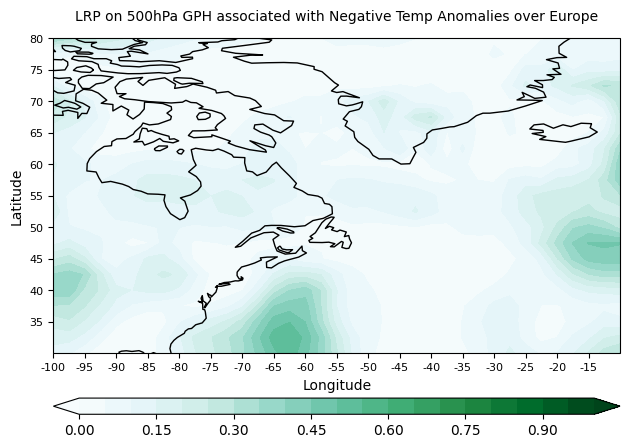

In [134]:
pos = np.array(posXtrain_grad)
pos.reshape((len(posXtrain_grad),777))
#Convert the list to an array to make processing simpler and reshape it into a 2-D map (our inputs were vectorized)
posLRP_heatmaps = pos.reshape(pos.shape[0], 21, 37)
posLRP_heatmaps_scaled = posLRP_heatmaps/np.nanmax(posLRP_heatmaps, axis=(-2,-1))[:,np.newaxis,np.newaxis]
posLRP_heatmaps_mean = np.nanmean(posLRP_heatmaps_scaled, axis=0)

neg = np.array(negXtrain_grad )
neg.reshape((len(negXtrain_grad),777))
negLRP_heatmaps = neg.reshape(neg.shape[0], 21, 37)
negLRP_heatmaps_scaled = negLRP_heatmaps/np.nanmax(negLRP_heatmaps, axis=(-2,-1))[:,np.newaxis,np.newaxis]
negLRP_heatmaps_mean = np.nanmean(negLRP_heatmaps_scaled, axis=0)

#lat
lats = np.arange(80, 29.5, -2.5)
#lon
lons = np.arange(-100, -9.5, 2.5)
###########################################################################################################
# plot the original data 
color = 'BuGn' 
colorbarMin = 0
colorbarMax = 1
colorspace = 0.05
level = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)
ax = plt.axes(projection=ccrs.cartopy.crs.PlateCarree(central_longitude=180))
h = ax.contourf(lons, lats, negLRP_heatmaps_mean, level, transform=ccrs.PlateCarree(), cmap=color,extend='both')
#plt.contourf(lons, lats, LRP_heatmaps_mean, level, cmap=color,extend='both')
cbar = plt.colorbar(h, orientation='horizontal', shrink=1,fraction=0.1,pad=0.1,aspect=35)
cbar.ax.tick_params(labelsize=10) 
#Add in the coordinate system:
long = np.arange(-100, -10, 5)
latg = np.arange(80, 30 ,-5)
ax.set_xticks(long, crs=ccrs.PlateCarree());
ax.set_yticks(latg, crs=ccrs.PlateCarree());
ax.set_xticklabels(long,fontsize=8)
ax.set_yticklabels(latg,fontsize=8)
ax.set_ylabel('Latitude',fontsize=10);
ax.set_xlabel('Longitude',fontsize=10);

#Add in the continents
#define the coastlines, the color (#000000) and the resolution (110m) 
feature1 = cf.NaturalEarthFeature(
    name='coastline', category='physical',
    scale='110m',
    edgecolor='#000000', facecolor='none')

ax.add_feature(feature1)

plt.tight_layout()
#Set a title for your map:
title = 'LRP on 500hPa GPH associated with Negative Temp Anomalies over Europe'
plt.title(title,fontsize=10, y=1.03)
#plt.savefig("LRP_take1.png")

In [105]:
tf.keras.backend.clear_session()

In [106]:
#analysis.shape

In [107]:
#Convert the list to an array to make processing simpler and reshape it into a 2-D map (our inputs were vectorized)
LRP_heatmaps = analysis.reshape(analysis.shape[0], 21, 37)

#Normalize each heatmap to have a maximum value of 1 so all samples can be compared equally
LRP_heatmaps_scaled = LRP_heatmaps/np.nanmax(LRP_heatmaps, axis=(-2,-1))[:,np.newaxis,np.newaxis]

#Now take the mean across all samples to make a composite...
LRP_heatmaps_mean = np.nanmean(LRP_heatmaps_scaled, axis=0)

/tmp/ipykernel_2172700/2154470865.py:5: RuntimeWarning: invalid value encountered in divide
  LRP_heatmaps_scaled = LRP_heatmaps/np.nanmax(LRP_heatmaps, axis=(-2,-1))[:,np.newaxis,np.newaxis]


In [108]:
LRP_heatmaps_mean.shape

(21, 37)

In [109]:
#lat
lats = np.arange(80, 29.5, -2.5)
#lon
lons = np.arange(-100, -9.5, 2.5)

Text(0.5, 1.03, 'LRP on 500hPa GPH associated with Temp Anomalies over Europe')

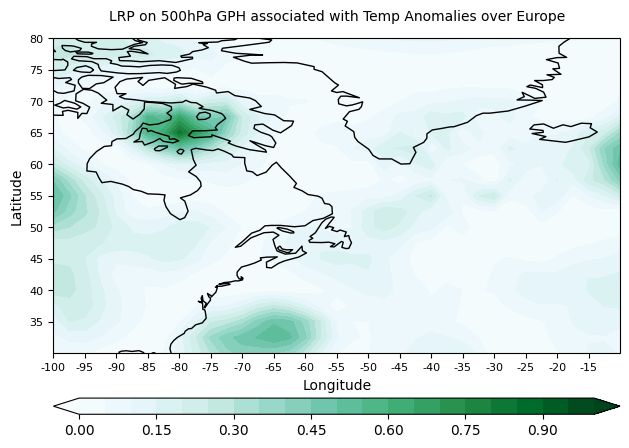

In [110]:
# plot the original data 
color = 'BuGn' 
colorbarMin = 0
colorbarMax = 1
colorspace = 0.05
level = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)
ax = plt.axes(projection=ccrs.cartopy.crs.PlateCarree(central_longitude=180))
h = ax.contourf(lons, lats, LRP_heatmaps_mean, level, transform=ccrs.PlateCarree(), cmap=color,extend='both')
#plt.contourf(lons, lats, LRP_heatmaps_mean, level, cmap=color,extend='both')
cbar = plt.colorbar(h, orientation='horizontal', shrink=1,fraction=0.1,pad=0.1,aspect=35)
cbar.ax.tick_params(labelsize=10) 
#Add in the coordinate system:
long = np.arange(-100, -10, 5)
latg = np.arange(80, 30 ,-5)
ax.set_xticks(long, crs=ccrs.PlateCarree());
ax.set_yticks(latg, crs=ccrs.PlateCarree());
ax.set_xticklabels(long,fontsize=8)
ax.set_yticklabels(latg,fontsize=8)
ax.set_ylabel('Latitude',fontsize=10);
ax.set_xlabel('Longitude',fontsize=10);

#Add in the continents
#define the coastlines, the color (#000000) and the resolution (110m) 
feature1 = cf.NaturalEarthFeature(
    name='coastline', category='physical',
    scale='110m',
    edgecolor='#000000', facecolor='none')

ax.add_feature(feature1)

plt.tight_layout()
#Set a title for your map:
title = 'LRP on 500hPa GPH associated with Temp Anomalies over Europe'
plt.title(title,fontsize=10, y=1.03)
#plt.savefig("LRP_take1.png")